# Abstract

The target was to create a model able to accurately predict fraudulent transactions. Due to fraudulent transactions typically being quiet rare and occuring throughout huge volumes of normal transactions the main goal was to identify as many frauds as possible, i.e. focussing on recall rather than accuracy.

In the end I was able to build a model that correctly identified c. 98.5% of fraudulent transactions while keeping a precision of c. 83.1%. Further increasing precision through tuning the models paramenters always led to a decrease in recall. Considering that in a real-life context not identifying fraudulent transactons is way more costly than someone having to unblock a regular transaction classified as fraudulent I decided to not go any lower with the models recall for now.

I was able to achieve these results via XGBoost and through exhaustive EDA helping with feature selection and engineering as well as the implementation of oversampling techniques (due to extreme class imbalance between normal/fraud transactions).

# **Exploratory Data Analysis**

In [1]:
#Import libraries

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings; warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost.data")


In [2]:
data = pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')

## General overview

In [3]:
#Generate overview - 1
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
#Generate overview - 2
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

The dataset consists of six numerical features of which one appears to capture time ('step'). Further we also have categorical features, most importantly the transaction type. The features of 'nameOrig' and 'nameDest'  (categorical) will not be accessed as one goal is to set-up a generalised model applicable to other data source. Training the model on specific names (either names of targets or fraudulent actors) might lead the model to focus on those which might not be found in other data sets. 
Prior accessing each features distribution regarding fraudulent transactions ('isFraud' = 1) vs regular transactions ('isFraud' = 0) we will look at the distribution of transaction types.

## Check for class imbalance

/tmp/ipykernel_19/1368046137.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['isFraud'], sort = True)


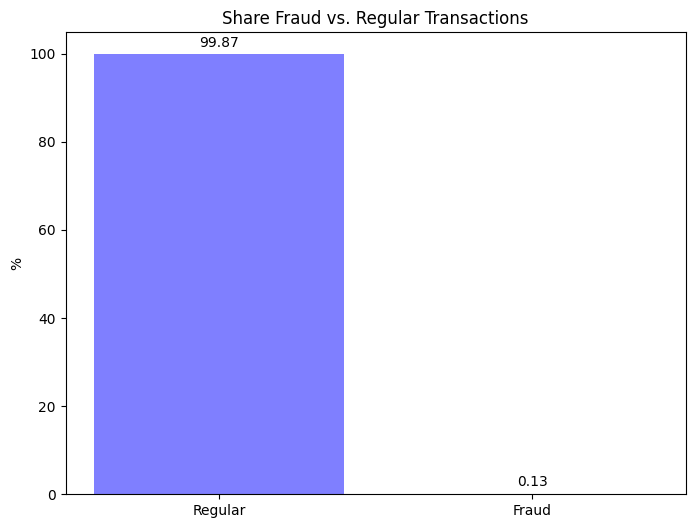

In [5]:
# Count the occurrences of fraud and no fraud and put them into a dataframe
count_classes = pd.value_counts(data['isFraud'], sort = True)

# Rename index to add descriptive names
count_classes.index = ['Regular', 'Fraud']

# Calculate percentage of each class in the dataset
percentages = 100 * count_classes / len(data)

# Create bar plot
plt.figure(figsize=(8,6))
bars = plt.bar(count_classes.index, percentages, alpha=0.5, color=['b', 'r'])
plt.title("Share Fraud vs. Regular Transactions")
plt.xticks(range(2), ['Regular', 'Fraud'])
plt.ylabel("%")

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

plt.show()

As expected the dataset of transactions is highly imbalanced. We will employ sampling techniques to deal with the imbalance post-EDA.
Further we will put more emphisis on recall and precision rather than accuracy as valuation metrics, since the imbalance in data might skew towards regular transactions leading to an overclassification of that type not detected by fraud.

## Overview 'step'

In [6]:
# Define function for generating normalised histograms based on features provided

def generate_normalized_histogram(df, features):
    for i, feature in enumerate(features):
        # Filter the DataFrame for 'isFraud' = 0 and 'isFraud' = 1
        fraud = df[df['isFraud'] == 1][feature]
        regular = df[df['isFraud'] == 0][feature]

        # Compute histogram bins for both 'fraud' and 'regular' based on 'regular' data
        regular_counts, bins = np.histogram(regular, bins=50, density=True)
        fraud_counts, _ = np.histogram(fraud, bins=bins, density=True)
        
        # Normalize to make it a distribution
        fraud_counts /= fraud_counts.sum()
        regular_counts /= regular_counts.sum()

        # Get bin center
        bins_center = bins[:-1] + np.diff(bins)/2
        
        # Generate the histograms
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(bins_center, fraud_counts, alpha=0.3, color='red', width=np.diff(bins), label='Fraud')
        ax.bar(bins_center, regular_counts, alpha=0.3, color='blue', width=np.diff(bins), label='Regular')

        # Title and labels
        ax.set_title(f'Normalized Distribution of "{feature}" - Fraud Vs Regular')
        ax.set_xlabel(f'{feature}')
        ax.set_ylabel('Share of total fraud/regular')
        ax.legend()

        plt.show()

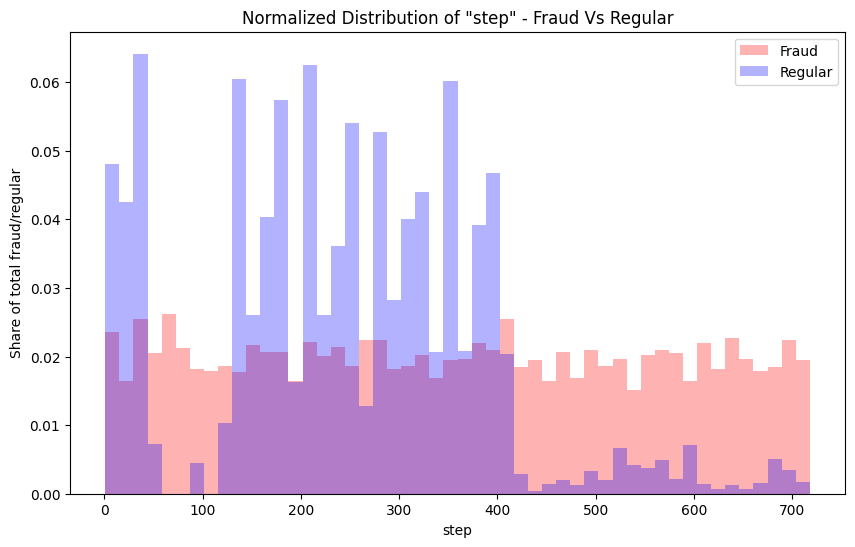

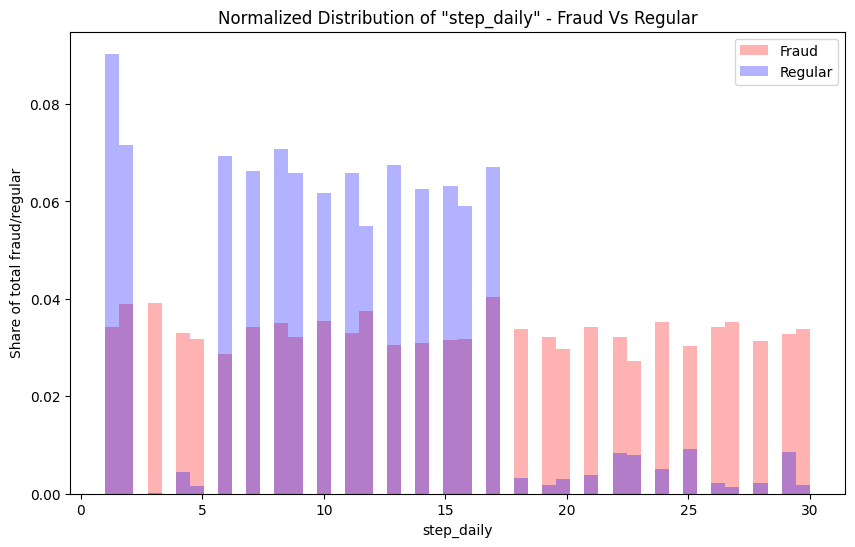

In [7]:
# Filter data to only include step + isFraud
data_for_step_plot = data[['step', 'isFraud']].copy()

# Generate a new column displaying days rather than hours
data_for_step_plot['step_daily'] = np.ceil(data_for_step_plot['step'] / 24)

# Generate histogram
features = ['step','step_daily']
generate_normalized_histogram(data_for_step_plot, features)


According to the author of the dataset 'step' captures hours. Since no further information is provided we assume that it recorded the hours since the author started recording the transactions within the dataset. To identify potential seasonality (e.g. hightened fraud activity around 10am each day or on fridays) I plotted the histograms of hours and days. Eventhough we can absorve differences between fraud/regular transactions when it comes to their occurance, there is no clear seasonality. Since the aim is for a generalised model we will exclude 'step' from the data set for continued analysis. 

## Overview numeric features

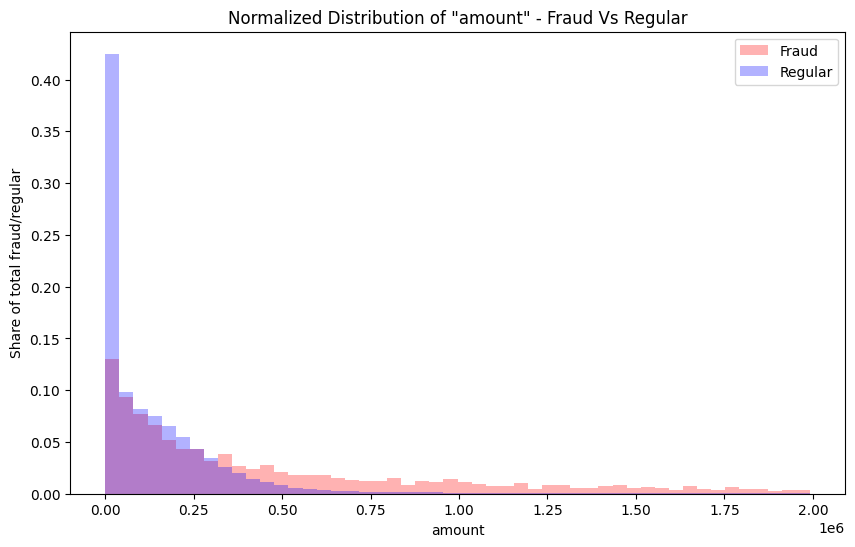

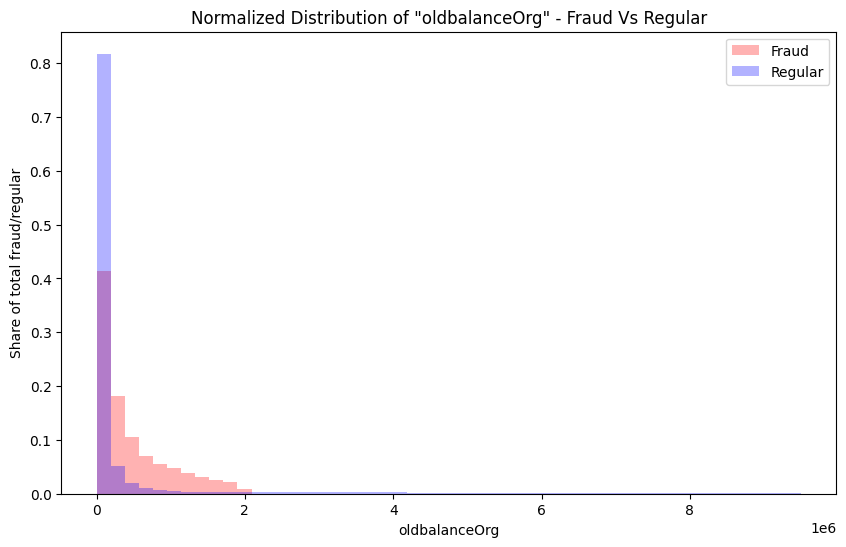

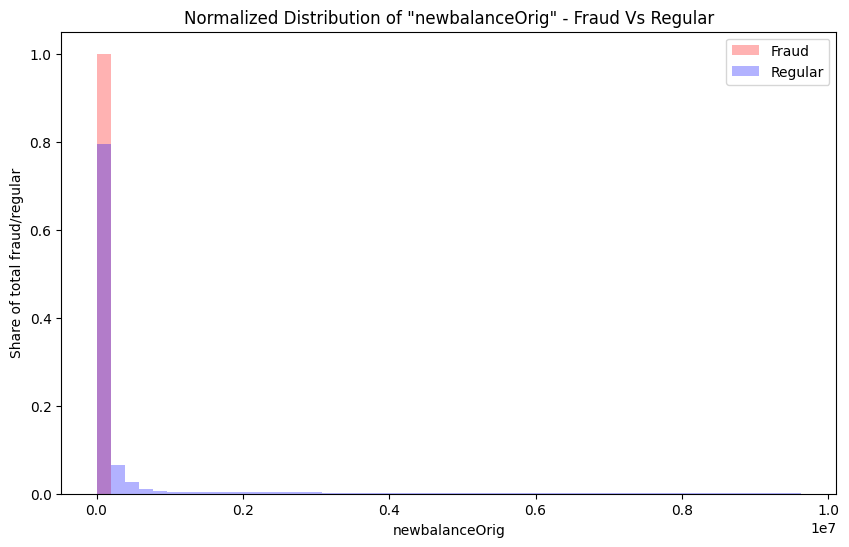

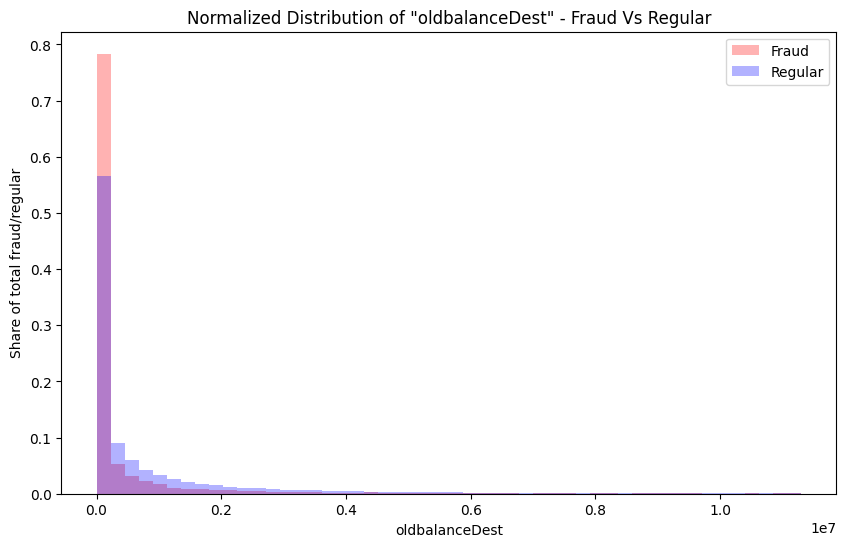

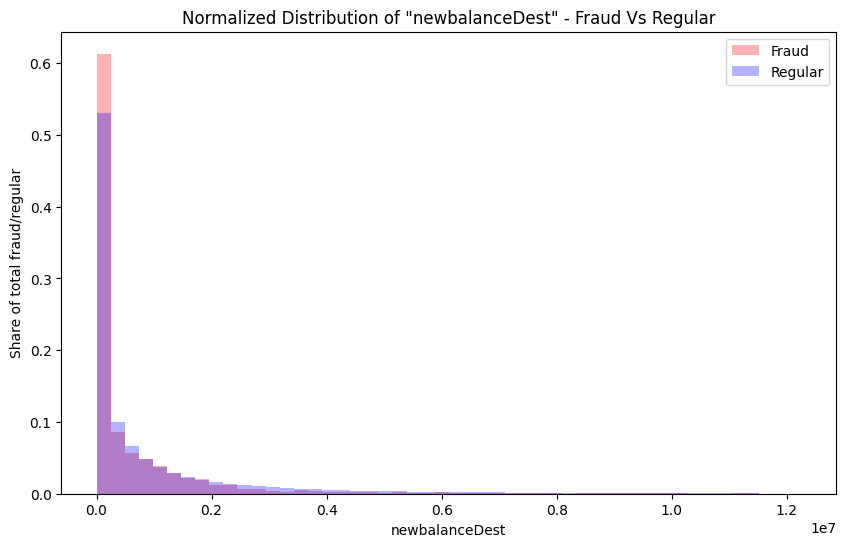

In [8]:
# Remove outliers of numeric features for plots
# Focus on numeric features, remove step and don't consider isFraud in outlier analysis
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('step')
numeric_features.remove('isFraud')

# Set-up numeric df for outlier analysis
data_numeric = data[numeric_features]

# Calculate z-scores
z_scores = np.abs(stats.zscore(data_numeric))

# Define threshold for outliers
threshold = 3

# Create mask where true values are not outliers  
mask = (z_scores < threshold).all(axis=1)

# Prepare 'data_for_plot' and exclude outliers based on the numeric features while preserving 'isFraud'
data_for_numeric_plot = data.loc[mask]

# Generate plot
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
generate_normalized_histogram(data_for_numeric_plot, features)

Looking at numeric values behavior between fraud vs regular transactions, we see that fraudulent transactions consists of higher-value transactions ('amount') and higher-value accounts/targets ('oldbalanceOrig') compared to regular transactions. Contrary the accounts where money is transferred to (i.e. accounts of the fraudsters) is typically lower in value.

## Overview categorical features

In [9]:
# Define function for generating normalised bar plots based on features provided

def generate_normalized_barplot(df, features):
    for i, feature in enumerate(features):
        # Filter the DataFrame for 'isFraud' = 0 and 'isFraud' = 1
        fraud = df[df['isFraud'] == 1][feature]
        regular = df[df['isFraud'] == 0][feature]
        
        # Compute value_counts for both 'fraud' and 'regular'
        fraud_counts = fraud.value_counts(normalize=True)
        regular_counts = regular.value_counts(normalize=True)

        # Create new DataFrame for plotting
        plot_df = pd.DataFrame({'Fraud': fraud_counts, 'Regular': regular_counts})


        # Generate the bar plot
        ax = plot_df.plot(kind='bar', stacked=False, figsize=(10, 6), alpha=0.5)
        
        # Add value labels on top of each bar
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=9)

        
        # Title and labels
        plt.title(f'Normalized Distribution of "{feature}" - Fraud Vs Regular')
        plt.xlabel(f'{feature}')
        plt.ylabel('Share of total fraud/regular')
        plt.legend()

        plt.show()

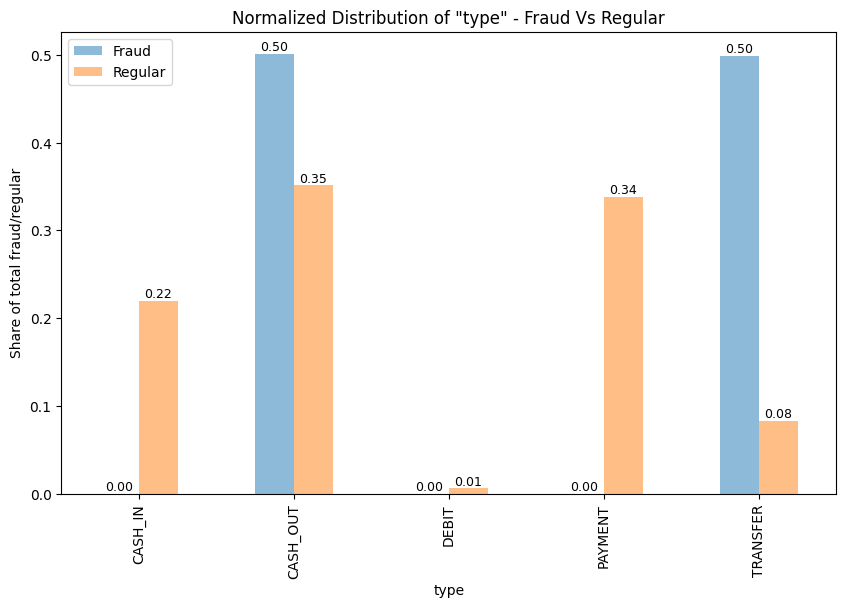

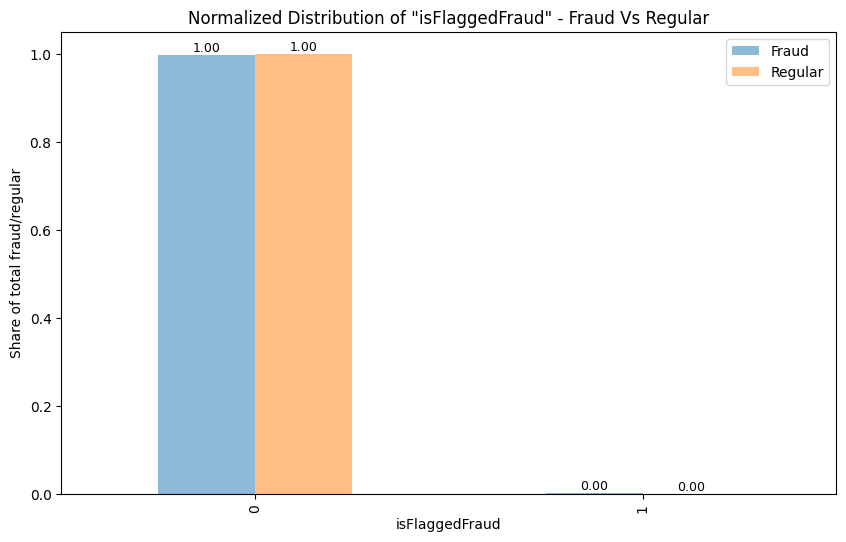

In [10]:
# Generate bar plot of 'type'
features = ['type','isFlaggedFraud']
generate_normalized_barplot(data, features)

Regarding the categorical features we can observe that fraudulent transaction only consist of cash_out and transfer transactions, i.e. money being transferred away out of originating accounts. Further we can observe that only an insignificant amount of fraudulent transactions was flagged as fraud.

# **Data preparation, feature selection & engineering**

## Remove features deemed unnecessary

Prior engeneering we will already remove the following features:
- Exclude names of originating and destination accounts to not train the model to focus on specific actors
- Exclude 'step' so the model will be generally applicable w/o considering time as a feature
- Exclude 'isFlaggedFraud' as we seek to make a generalised model relying on as little information as possible

In [11]:
# Remove features stated above
data_model = data.copy()
data_model = data_model.drop(['nameOrig','nameDest','step','isFlaggedFraud'], axis=1)

## Engineering of 'type'

Since we noticed that transaction types only occured the type 'cash_out' and 'transfer' were are going only include these two in our final dataset

In [12]:
# One-Hot encoding for 'type'
dummies = pd.get_dummies(data_model['type'], prefix='type').astype(int)

#dummies = dummies.astype(int)
data_model = pd.concat([data_model.drop('type', axis=1), dummies], axis=1)

In [13]:
# Remove all non-CASH_OUT/TRANSFER types
data_model['prelim'] = data_model['type_CASH_OUT'] + data_model['type_TRANSFER']
data_model = data_model[data_model['prelim'] != 0]

In [14]:
data_model = data_model.drop(['type_CASH_IN','type_DEBIT','type_PAYMENT','prelim'], axis = 1)

## Add weights by transaction size

Since we were able to identify that fraudulent transactions tend to be higher value compared to regular transactions we are going to weight higher value transaction higher. For that we are going to split the dataset into 25 different buckets using log10. The fraud-rate (% of fraudulent transactions as % of bucket) will be equal to the corresponding weighting.

In [15]:
# Number of buckets
num_buckets = 25

# Filter out non-positive values to avoid divide-by-zero and invalid values in logarithmic binning
positive_amounts = data_model['amount'][data_model['amount'] > 0]

# Create logarithmic bins
bins = np.logspace(np.log10(positive_amounts.min()), np.log10(positive_amounts.max()), num_buckets)

# Assign each 'amount' to a bucket based on the bins
data_model['bucket'] = np.digitize(data_model['amount'], bins)

# Map bucket indices to the upper bound of each bucket range
data_model['bucket'] = data_model['bucket'].apply(lambda x: bins[x] if x > 0 else np.nan)

# Calculate the share of 'isFraud' = 1 within each bucket
bucket_fraud_share = data_model.groupby('bucket')['isFraud'].mean()

# Replace NaN values with 0 in the fraud share
bucket_fraud_share = bucket_fraud_share.fillna(0)

# Map the fraud share to each row in the DataFrame
data_model['fraud_share'] = data_model['bucket'].map(bucket_fraud_share)

# Replace NaNs in fraud share with 0
data_model['fraud_share'] = data_model['fraud_share'].fillna(0)

# Round buckets
data_model['bucket'] = data_model['bucket'].round(1)

data_model.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER,bucket,fraud_share
2,181.00,181.0,0.0,0.0,0.00,1,0,1,369.6,0.011230
3,181.00,181.0,0.0,21182.0,0.00,1,1,0,369.6,0.011230
15,229133.94,15325.0,0.0,5083.0,51513.44,0,1,0,298136.0,0.001385
19,215310.30,705.0,0.0,22425.0,0.00,0,0,1,298136.0,0.001385
24,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1,775639.0,0.003040


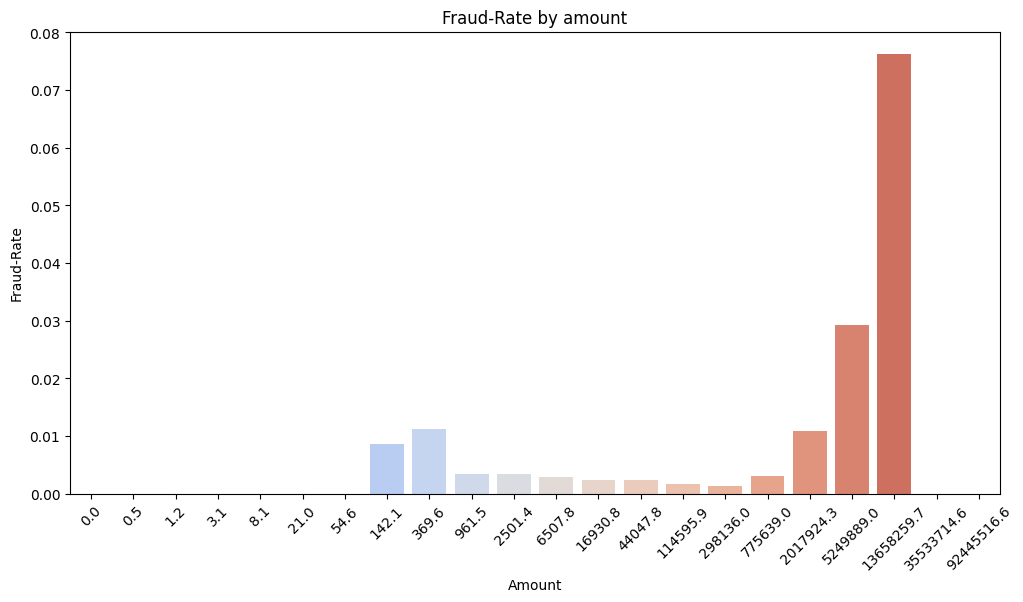

In [16]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='bucket', y='fraud_share', data=data_model, palette='coolwarm')

plt.title('Fraud-Rate by amount')
plt.xlabel('Amount')
plt.ylabel('Fraud-Rate')
plt.xticks(rotation=45)
plt.show()

In [17]:
data_model['fraud_share'] = data_model['fraud_share']+1

## Create a feature capturing change in Dest. account
Generate a new feature displaying the change in the destination account (change in Originators account is already captured by 'amount')

In [18]:
data_model['balanceChange_Dest'] = data_model['newbalanceDest'] - data_model['oldbalanceDest']

## Remove highly correlated variables to avoid multicollinearity 

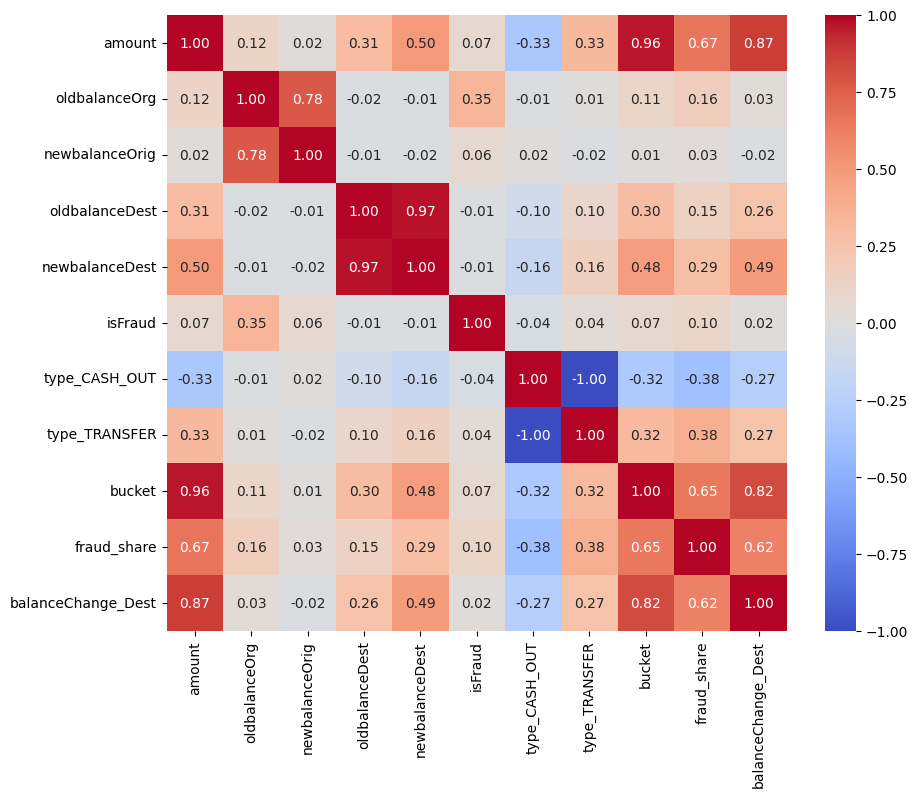

In [19]:
corr = data_model.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [20]:
data_model = data_model.drop(['bucket'], axis=1)

## Remove outliers (only of majority class) based on IQR

In [21]:
import pandas as pd

def remove_outliers_iqr(data_model, target_column):
    # Separate the majority and minority classes
    majority_class = data_model[data_model[target_column] == 0]
    minority_class = data_model[data_model[target_column] == 1]
    
    # Iterate through each numerical column
    for column in majority_class.select_dtypes(include=['number']).columns:
        if column == target_column:
            continue
        
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = majority_class[column].quantile(0.25)
        Q3 = majority_class[column].quantile(0.75)
        
        # Calculate IQR
        IQR = Q3 - Q1
        
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        majority_class = majority_class[(majority_class[column] >= lower_bound) & (majority_class[column] <= upper_bound)]
    
    # Combine the cleaned majority class with the minority class
    cleaned_data_model = pd.concat([majority_class, minority_class])
    
    return cleaned_data_model

In [22]:
data_model = remove_outliers_iqr(data_model,'isFraud')

## Split X and y

In [23]:
y = data_model['isFraud']
X = data_model.drop(['isFraud'], axis=1)

# **Model set-up, evaluation and summary**

**Important notice**

For the following GPU has to be turned on (GPU T4 x2) as the algorythm we are going to employ will be NVIDIAs optimized RAPIDS cuML version.

We are going to define the random oversampling function used on the model ourselfes as the import currently does no work.

In [24]:
def random_oversample(df, feature, ratio):    
    # Separate majority and minority classes
    df_majority = df.loc[df[feature] == df[feature].mode()[0]].copy()
    df_minority = df.loc[df[feature] != df[feature].mode()[0]].copy()
    
    # Calculate new minority size
    new_minority_size = int(len(df_majority) * ratio)

    # Oversample minority class
    df_minority_oversampled = df_minority.sample(new_minority_size, replace=True)

    # Combine majority class with oversampled minority class
    df_oversampled = pd.concat([df_majority, df_minority_oversampled], axis=0)
    
    return df_oversampled

## Model set-up and evaluation

In the following we are going to employ XGBoost and cross-validation to generate evaluatable predictions. As outlined during the EDA we will focus on recall and precision (especially for 'isFraud' = True). 
During the training process the testing data of each fold will be oversampled by ratio of 1:0.5 as to help the model by having more examples of fraud.

Our main target is to capture most fraudulent transaction (i.e. high recall of isFraud = 1) while striving for the highest precision possible (i.e. high precision of isFraud = 1). Achivieng high recall is of more importance to us as missing of fraudulent transaction is more costly than falsely classifying a regular transaction as fraud. Nonetheless our target is still to achive precision at least higher than 80% while recall should be in the high 90s.

Testing of optimal paramenters regarding learning rate, boost_round and y_pred will be performed offline, thus this project only shows the final result.

In [25]:
import cudf
import cupy as cp
from cuml.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score

# Convert to cuDF if not already
X_cudf = cudf.DataFrame(X)
y_cudf = cudf.Series(y)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_list = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_cudf, y_cudf)):
    X_tr, X_val = X_cudf.iloc[train_idx], X_cudf.iloc[val_idx]
    y_tr, y_val = y_cudf.iloc[train_idx], y_cudf.iloc[val_idx]

    training_merged = X_tr.copy()
    training_merged['isFraud'] = y_tr
    training_merged = training_merged.to_pandas()

    training_merged_oversampled = random_oversample(training_merged, 'isFraud', 0.5)

    y_tr = training_merged_oversampled['isFraud']
    X_tr = training_merged_oversampled.drop(['isFraud'], axis=1)

    X_tr = cudf.DataFrame(X_tr)
    y_tr = cudf.Series(y_tr)

    X_tr = X_tr.astype({col: 'int32' for col in X_tr.columns if X_tr[col].dtype == 'bool'})
    X_val = X_val.astype({col: 'int32' for col in X_val.columns if X_val[col].dtype == 'bool'})

    training_data = xgb.DMatrix(X_tr, label=y_tr)
    testing_data = xgb.DMatrix(X_val, label=y_val)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'learning_rate': 0.05,
        'verbosity': 0,
        'device': 'cuda'
    }

    model = xgb.train(
        params,
        training_data,
        num_boost_round=1000,
        evals=[(testing_data, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    y_pred = model.predict(testing_data)
    y_pred_binary = (y_pred > 0.75).astype('int32')

    y_val_np = y_val.to_numpy()
    y_pred_binary_np = cp.asnumpy(y_pred_binary)

    f1 = f1_score(y_val_np, y_pred_binary_np)
    precision = precision_score(y_val_np, y_pred_binary_np, average=None)
    recall = recall_score(y_val_np, y_pred_binary_np, average=None)

    metrics_list.append({
        'fold': fold + 1,
        'f1_score': float(f1),
        'precision_0': float(precision[0]),
        'precision_1': float(precision[1]),
        'recall_0': float(recall[0]),
        'recall_1': float(recall[1])
    })

# Convert to cuDF DataFrame
metrics_df = cudf.DataFrame(metrics_list)

# Compute averages
avg_recall_1 = float(cp.mean(cp.array([m['recall_1'] for m in metrics_list])))
avg_precision_1 = float(cp.mean(cp.array([m['precision_1'] for m in metrics_list])))

# Show metrics per fold
print(metrics_df)

# Final summary sentence
print(f"On average c. {avg_recall_1 * 100:.2f}% of fraudulent transactions were caught (recall_y1) while c. {(1 - avg_precision_1) * 100:.2f}% of normal transactions were misclassified as fraud (1 - precision_y1)")



   fold  f1_score  precision_0  precision_1  recall_0  recall_1
0     1  0.894268     0.999881     0.823680  0.998866  0.978089
1     2  0.905618     0.999898     0.840897  0.998995  0.981132
2     3  0.892671     0.999944     0.813000  0.998768  0.989653
3     4  0.912489     0.999898     0.852832  0.999084  0.981121
4     5  0.902214     0.999894     0.835496  0.998955  0.980512
On average c. 98.21% of fraudulent transactions were caught (recall_y1) while c. 16.68% of normal transactions were misclassified as fraud (1 - precision_y1)


## Summary

We were able to build a model that correctly identified c. 98.5% of fraudulent transactions while keeping a precision of c. 83.1%. Further increasing precision through tuning the models paramenters always led to a decrease in recall. 

Considering that in a real-life context not identifying fraudulent transactons is way more costly than someone having to unblock a regular transaction classified as fraudulent I decided to not go any lower with the models recall.
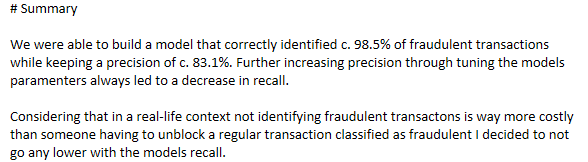
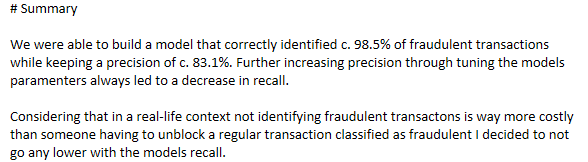
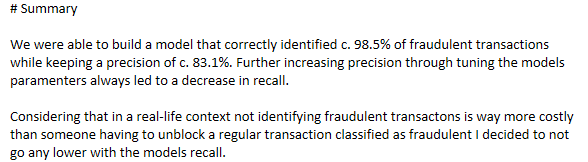